## Initialize notebook and download dat

In [1]:
!pip install kaggle

In [19]:
!pip install fancyimpute

In [21]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [4]:
# Upload your kaggle api key
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [5]:
!rm -r data/
!mkdir data/

rm: cannot remove 'data/': No such file or directory


In [6]:
!kaggle competitions download -c titanic

  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 22.7MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 27.2MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.43MB/s]


In [8]:
!mv gender_submission.csv data/
!mv test.csv data/
!mv train.csv data/

## Prepare data

In [9]:
df = pd.read_csv("./data/train.csv")

In [10]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**There are missing values in columns: Age, Cabin, and Embarked. We will replace the missing values using a multiple imputer. But first, let's look at data at the Age column compared to passenger class.**

Text(0, 0.5, 'Age')

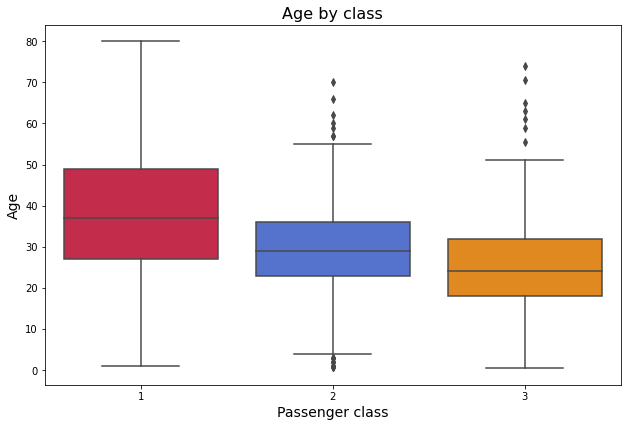

In [15]:
fig = plt.figure(figsize=(8, 5))
axes = fig.add_axes([0,0,1,1])
sns.boxplot(y='Age', x='Pclass', data=df, palette=['crimson', 'royalblue', 'darkorange'], ax=axes)
axes.set_title('Age by class', fontsize=16)
axes.set_xlabel('Passenger class', fontsize=14)
axes.set_ylabel('Age', fontsize=14)

**We can see that the higher the class (3 being the highest), the lower the age on average**

Drop the cabin column as there are too many missing values

In [22]:
df = df.drop(columns=['Cabin'], axis=1)

Replace the missing age values using a multiple imputer. 

**A multiple imputer does an iterated round-robin fashion: at each step, a feature column is designated as output y and the other feature columns are treated as inputs X. A regressor is fit on (X, y) for known y. Then, the regressor is used to predict the missing values of y. This is done for each feature in an iterative fashion, and then is repeated for max_iter imputation rounds. The results of the final imputation round are returned.**

[Source](https://scikit-learn.org/stable/modules/impute.html)

Use a multiple imputer to impute the missing age values

In [39]:
# remove unnecesary columns
imp_df = df
imp_df = imp_df.drop(columns=['Name'], axis=1)
imp_df = imp_df.drop('Ticket', axis=1)
imp_df = imp_df.drop('Embarked', axis=1)
imp_df['Sex'].replace(['female','male'],[0,1],inplace=True)
imp_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,1,22.0,1,0,7.2500
1,2,1,1,0,38.0,1,0,71.2833
2,3,1,3,0,26.0,0,0,7.9250
3,4,1,1,0,35.0,1,0,53.1000
4,5,0,3,1,35.0,0,0,8.0500


In [40]:
# perform the multiple imputation
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(imp_df)
imp_trans_df = pd.DataFrame(imp.transform(imp_df))
imp_trans_df.columns = list(imp_df.columns.values)
imp_trans_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1.0,0.0,3.0,1.0,22.0,1.0,0.0,7.2500
1,2.0,1.0,1.0,0.0,38.0,1.0,0.0,71.2833
2,3.0,1.0,3.0,0.0,26.0,0.0,0.0,7.9250
3,4.0,1.0,1.0,0.0,35.0,1.0,0.0,53.1000
4,5.0,0.0,3.0,1.0,35.0,0.0,0.0,8.0500


In [41]:
df['Age'] = imp_trans_df['Age']

**Time to deal with the Embarked column**

In [43]:
df[df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


A quick google search shows that those passengers left from southampton, so we can confidently just set that value to 'S' and move on

In [44]:
df.loc[61, 'Embarked'] = ['S']
df.loc[829, 'Embarked'] = ['S']

## Data Exploration

In [54]:
died, survived = df['Survived'].value_counts()
died_ratio = round(died / (died+survived),3)
survived_ratio = round(survived / (died+survived),3)
print(f"{died} passengers ({died_ratio}%) died")
print(f"{survived} passengers ({survived_ratio}%) survived")

549 passengers (0.616%) died
342 passengers (0.384%) survived


Analyze survival by column

In [57]:
list(df.columns.values)

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Embarked']

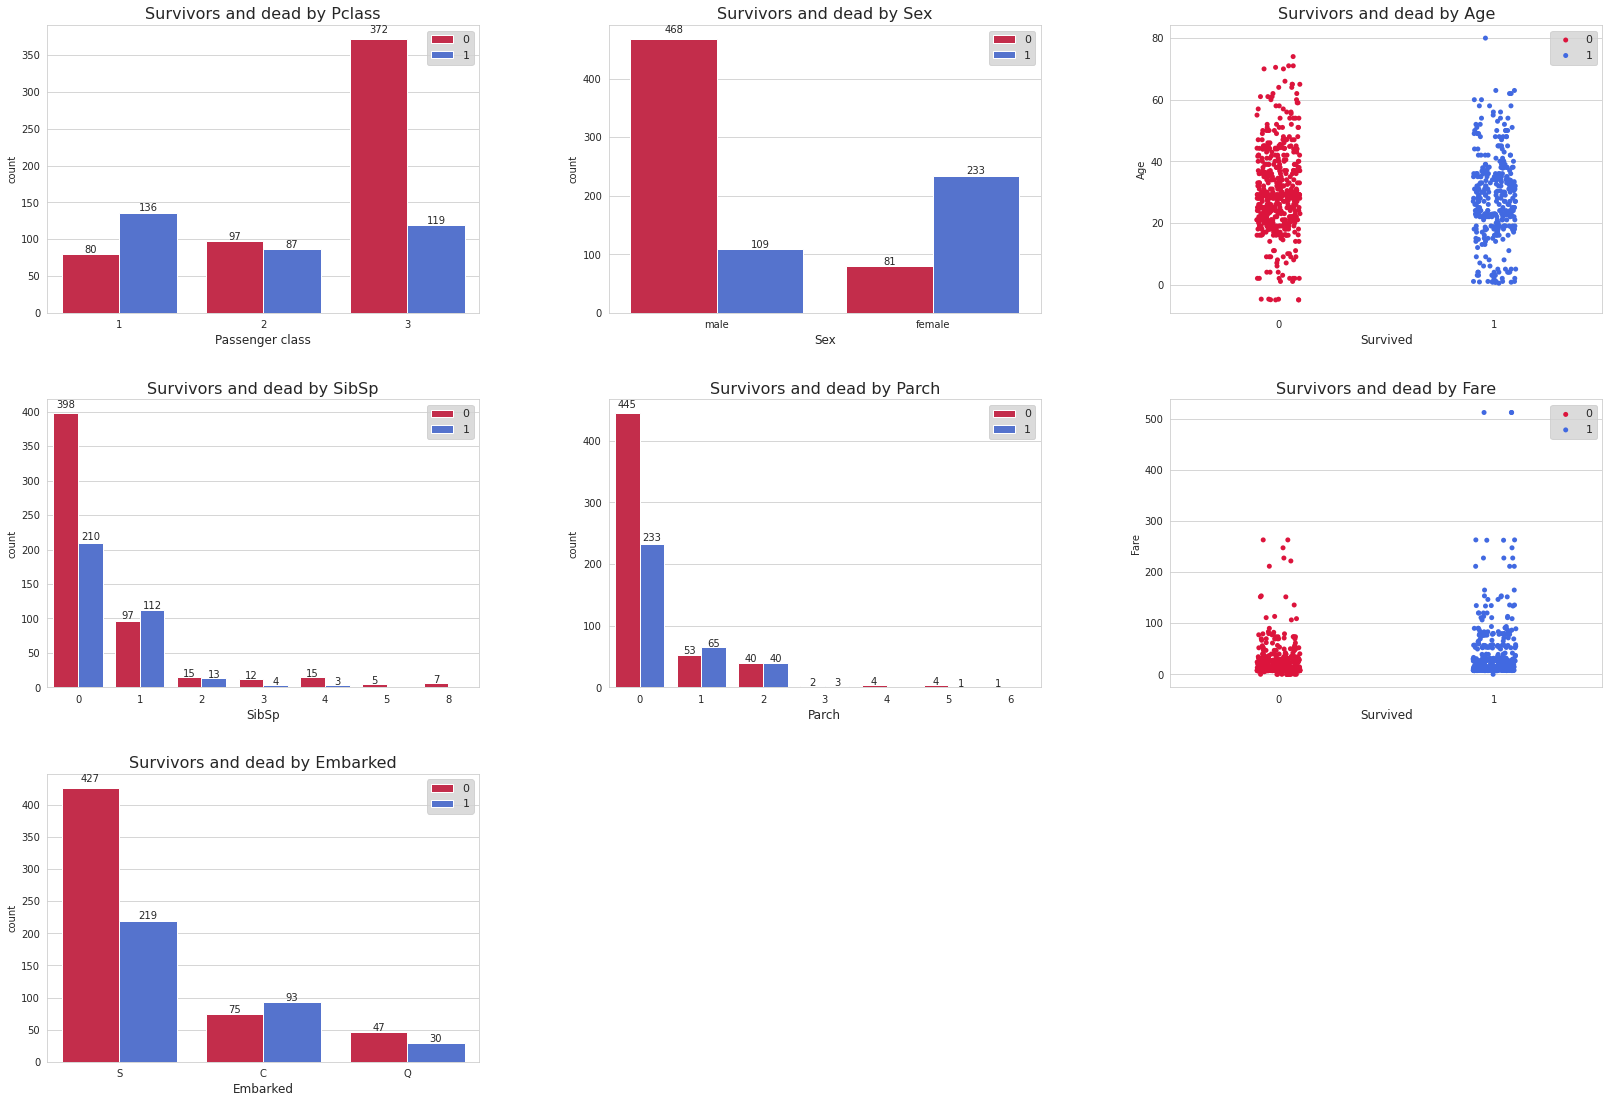

In [65]:
figure = plt.figure()
sns.set_style('whitegrid')
axes1 = figure.add_axes([0, 0, 1, 1]) # Pclass
axes2 = figure.add_axes([1.3, 0, 1, 1]) # Sex 
axes3 = figure.add_axes([2.6, 0, 1, 1]) # Age
axes4 = figure.add_axes([0, -1.3, 1, 1]) # SibSp
axes5 = figure.add_axes([1.3, -1.3, 1, 1]) # Parch
axes6 = figure.add_axes([2.6, -1.3, 1, 1]) # Fare
axes7 = figure.add_axes([0, -2.6, 1, 1]) # Embarked

# Pclass
sns.countplot(x='Pclass', 
              hue='Survived', 
              data=df, 
              ax=axes1, 
              palette=['crimson', 'royalblue']
             )
axes1.set_title('Survivors and dead by Pclass', fontsize=16)
axes1.set_xlabel('Passenger class', fontsize=12)
for p in axes1.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    axes1.annotate('{:.0f}'.format(height), (x + width/2, y + height*1.02), ha='center')
axes1.legend(loc='upper right', facecolor='lightgray', fontsize=11)

# Sex
sns.countplot(x='Sex', 
              hue='Survived', 
              data=df, 
              ax=axes2, 
              palette=['crimson', 'royalblue']
             )
axes2.set_title('Survivors and dead by Sex', fontsize=16)
axes2.set_xlabel('Sex', fontsize=12)
for p in axes2.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    axes2.annotate('{:.0f}'.format(height), (x + width/2, y + height*1.02), ha='center')
axes2.legend(loc='upper right', facecolor='lightgray', fontsize=11)

# Age
sns.stripplot(x='Survived', 
              y='Age',
              data=df,
              ax=axes3,
              palette=['crimson', 'royalblue']
             )
axes3.set_title('Survivors and dead by Age', fontsize=16)
axes3.set_xlabel('Survived', fontsize=12)
axes3.legend(facecolor='lightgray', fontsize=11, labels=[0, 1])

#SibSp
sns.countplot(x='SibSp', 
              hue='Survived', 
              data=df, 
              ax=axes4, 
              palette=['crimson', 'royalblue']
             )
axes4.set_title('Survivors and dead by SibSp', fontsize=16)
axes4.set_xlabel('SibSp', fontsize=12)
for p in axes4.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    axes4.annotate('{:.0f}'.format(height), (x + width/2, y + height*1.02), ha='center')
axes4.legend(loc='upper right', facecolor='lightgray', fontsize=11)

# Parch
sns.countplot(x='Parch', 
              hue='Survived', 
              data=df, 
              ax=axes5, 
              palette=['crimson', 'royalblue']
             )
axes5.set_title('Survivors and dead by Parch', fontsize=16)
axes5.set_xlabel('Parch', fontsize=12)
for p in axes5.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    axes5.annotate('{:.0f}'.format(height), (x + width/2, y + height*1.02), ha='center')
axes5.legend(loc='upper right', facecolor='lightgray', fontsize=11)

# Fare
sns.stripplot(x='Survived', 
              y='Fare',
              data=df,
              ax=axes6,
              palette=['crimson', 'royalblue']
             )
axes6.set_title('Survivors and dead by Fare', fontsize=16)
axes6.set_xlabel('Survived', fontsize=12)
axes6.legend(facecolor='lightgray', fontsize=11, labels=[0, 1])

# Embarked
sns.countplot(x='Embarked', 
              hue='Survived', 
              data=df, 
              ax=axes7, 
              palette=['crimson', 'royalblue']
             )
axes7.set_title('Survivors and dead by Embarked', fontsize=16)
axes7.set_xlabel('Embarked', fontsize=12)
for p in axes7.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    axes7.annotate('{:.0f}'.format(height), (x + width/2, y + height*1.02), ha='center')
axes7.legend(loc='upper right', facecolor='lightgray', fontsize=11)

At a glance, it is easy to see that class, embarked, parch, SibSp, fare, and sex all contain some sort of correlation between their feature and who survived

**When looking at the parch column, we see that people who travelled with >1 children (Parch) were much likelier to survive. We see a similar correlation when looking at siblings (SibSP). This is likely due to the fact that those with values >1 were older and therfore had a higher class. A futher examination is warranted**

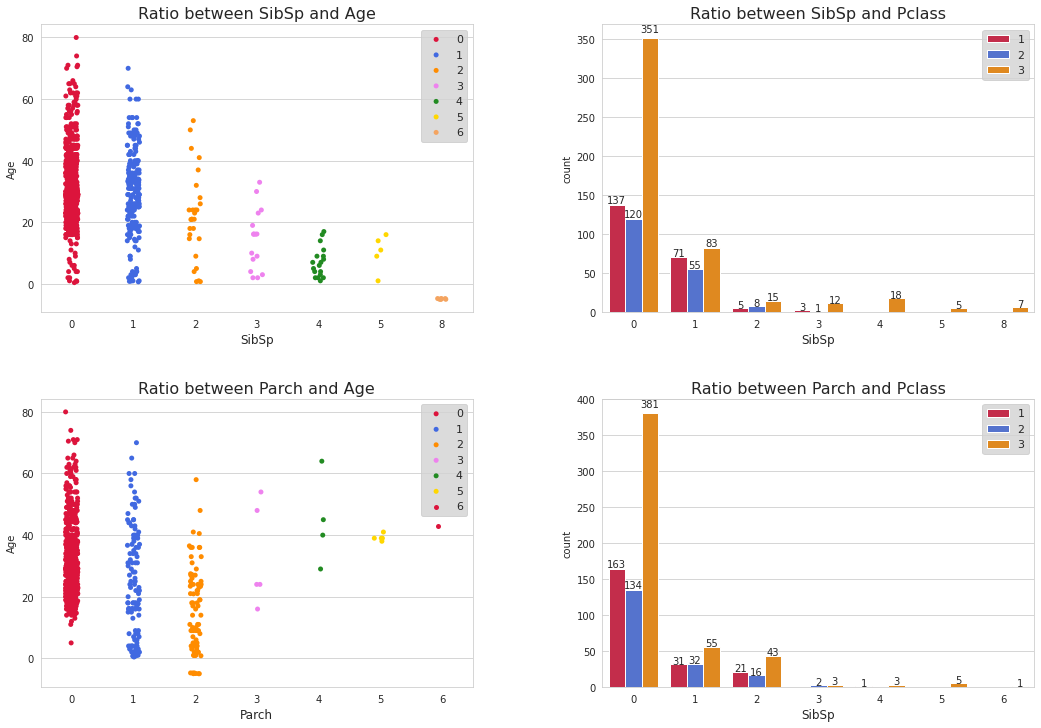

In [66]:
figure = plt.figure()
axes1 = figure.add_axes([0, 0, 1, 1]) # SibSp - Age
axes2 = figure.add_axes([1.3, 0, 1, 1]) # SibSp - Pclass
axes3 = figure.add_axes([0, -1.3, 1, 1]) # Parch - Age 
axes4 = figure.add_axes([1.3, -1.3, 1, 1]) # Parch - Pclass

# SibSp - Age
sns.stripplot(x='SibSp', 
              y='Age',
              data=df,
              ax=axes1,
              palette=['crimson', 'royalblue', 'darkorange', 'violet', 'forestgreen', 'gold', 'sandybrown', 'pink']
             )
axes1.set_title('Ratio between SibSp and Age', fontsize=16)
axes1.set_xlabel('SibSp', fontsize=12)
axes1.legend(facecolor='lightgray', fontsize=11, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])

# SibSp - Pclass
sns.countplot(x='SibSp', 
              hue='Pclass', 
              data=df, 
              ax=axes2, 
              palette=['crimson', 'royalblue', 'darkorange']
             )
axes2.set_title('Ratio between SibSp and Pclass', fontsize=16)
axes2.set_xlabel('SibSp', fontsize=12)
for p in axes2.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    axes2.annotate('{:.0f}'.format(height), (x + width/2, y + height*1.02), ha='center')
axes2.legend(loc='upper right', facecolor='lightgray', fontsize=11)

# Parch - Age
sns.stripplot(x='Parch', 
              y='Age',
              data=df,
              ax=axes3,
              palette=['crimson', 'royalblue', 'darkorange', 'violet', 'forestgreen', 'gold']
             )
axes3.set_title('Ratio between Parch and Age', fontsize=16)
axes3.set_xlabel('Parch', fontsize=12)
axes3.legend(facecolor='lightgray', fontsize=11, labels=[0, 1, 2, 3, 4, 5, 6])

# Parch - Pclass
sns.countplot(x='Parch', 
              hue='Pclass', 
              data=df, 
              ax=axes4, 
              palette=['crimson', 'royalblue', 'darkorange']
             )
axes4.set_title('Ratio between Parch and Pclass', fontsize=16)
axes4.set_xlabel('SibSp', fontsize=12)
for p in axes4.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    axes4.annotate('{:.0f}'.format(height), (x + width/2, y + height*1.02), ha='center')
axes4.legend(loc='upper right', facecolor='lightgray', fontsize=11)

**The assumption about the relation between age and the presence of fellow travelers was not confirmed. However, we observe that the biggest part of third-class passengers consists of passengers who were alone.**

**Next we will examine the Embarked column, as we see much different survivability rates between ports. We will compare the ticket price and the class of passengers to each port.**

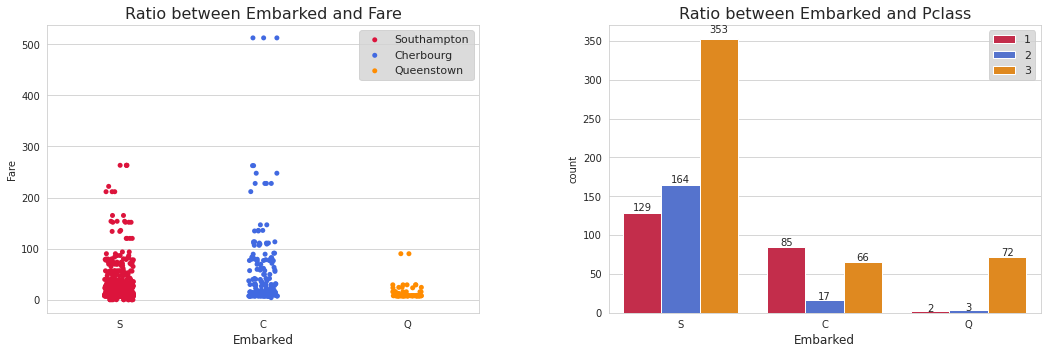

In [67]:
figure = plt.figure()
axes1 = figure.add_axes([0, 0, 1, 1]) # Emarked - Fare
axes2 = figure.add_axes([1.3, 0, 1, 1]) # Embarked - Pclass

# Emarked - Fare
sns.stripplot(x='Embarked', 
              y='Fare',
              data=df,
              ax=axes1,
              palette=['crimson', 'royalblue', 'darkorange']
             )
axes1.set_title('Ratio between Embarked and Fare', fontsize=16)
axes1.set_xlabel('Embarked', fontsize=12)
axes1.legend(facecolor='lightgray', fontsize=11, labels=['Southampton', 'Cherbourg', 'Queenstown'])

# SibSp - Pclass
sns.countplot(x='Embarked', 
              hue='Pclass', 
              data=df, 
              ax=axes2, 
              palette=['crimson', 'royalblue', 'darkorange']
             )
axes2.set_title('Ratio between Embarked and Pclass', fontsize=16)
axes2.set_xlabel('Embarked', fontsize=12)
for p in axes2.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    axes2.annotate('{:.0f}'.format(height), (x + width/2, y + height*1.02), ha='center')
axes2.legend(loc='upper right', facecolor='lightgray', fontsize=11)

**We see that a lot of people from Southampton were lower class, while those departing from Cherbourg consisted of higher class passengers, likely causing the initial correlatin we observed**

**It turns out that most of the observed correlations come back mainly to the class of passenger**

In [70]:
def one_hot_and_join(df, col):
  one_hot = pd.get_dummies(df[col])
  df = df.drop(col, axis=1)
  return df.join(one_hot)

for col in ['Sex', 'Embarked']:
  df = one_hot_and_join(df, col)
df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [71]:
scaler = StandardScaler()
norm = scaler.fit_transform(df[['Age', 'Fare']])
df_norm = pd.DataFrame({'Age': norm[ :, 0], 'Fare' : norm[ :, 1]}, columns=['Age', 'Fare'])
df['Age'] = df_norm['Age']
df['Fare'] = df_norm['Fare']
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
0,0,3,-0.534809,1,0,-0.502445,0,1,0,0,1
1,1,1,0.634618,1,0,0.786845,1,0,1,0,0
2,1,3,-0.242452,0,0,-0.488854,1,0,0,0,1
3,1,1,0.415350,1,0,0.420730,1,0,0,0,1
4,0,3,0.415350,0,0,-0.486337,0,1,0,0,1


In [72]:
x = df.drop(['Survived'], axis=1)
y = df['Survived']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [73]:
os = SMOTE(random_state=42)
columns = x_train.columns
os_data_x,os_data_y = os.fit_resample(x_train, y_train.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [75]:
knn_params = {'n_neighbors': list(range(3, 20, 2)),
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
          'metric':['euclidean', 'manhattan', 'chebyshev', 'minkowski']
         }
knn_model = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5)
knn_model.fit(os_data_x, os_data_y)
knn_predict = knn_model.predict(x_test)
knn_cm = confusion_matrix(y_test, knn_predict)
knn_score = knn_model.best_score_

In [76]:
svc_params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 100],
              'gamma':['scale', 'auto'], 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'] 
             }
svc_model = GridSearchCV(SVC(), svc_params, cv=5)
svc_model.fit(os_data_x, os_data_y)
svc_predict = svc_model.predict(x_test)
svc_cm = confusion_matrix(y_test, svc_predict)
svc_score = svc_model.best_score_

In [77]:
dt_params = {'criterion' : ['gini', 'entropy'],
              'splitter': ['random', 'best'], 
              'max_depth': list(range(3, 20, 2))
            }
dt_model = GridSearchCV(DecisionTreeClassifier(), dt_params, cv=5)
dt_model.fit(os_data_x, os_data_y)
dt_predict = dt_model.predict(x_test)
dt_cm = confusion_matrix(y_test, dt_predict)
dt_score = dt_model.best_score_

In [78]:
rf_params = {'criterion' : ['gini', 'entropy'],
             'n_estimators': list(range(5, 26, 5)),
             'max_depth': list(range(3, 20, 2))
            }
rf_model = GridSearchCV(RandomForestClassifier(), rf_params, cv=5)
rf_model.fit(os_data_x, os_data_y)
rf_predict = rf_model.predict(x_test)
rf_cm = confusion_matrix(y_test, rf_predict)
rf_score = rf_model.best_score_

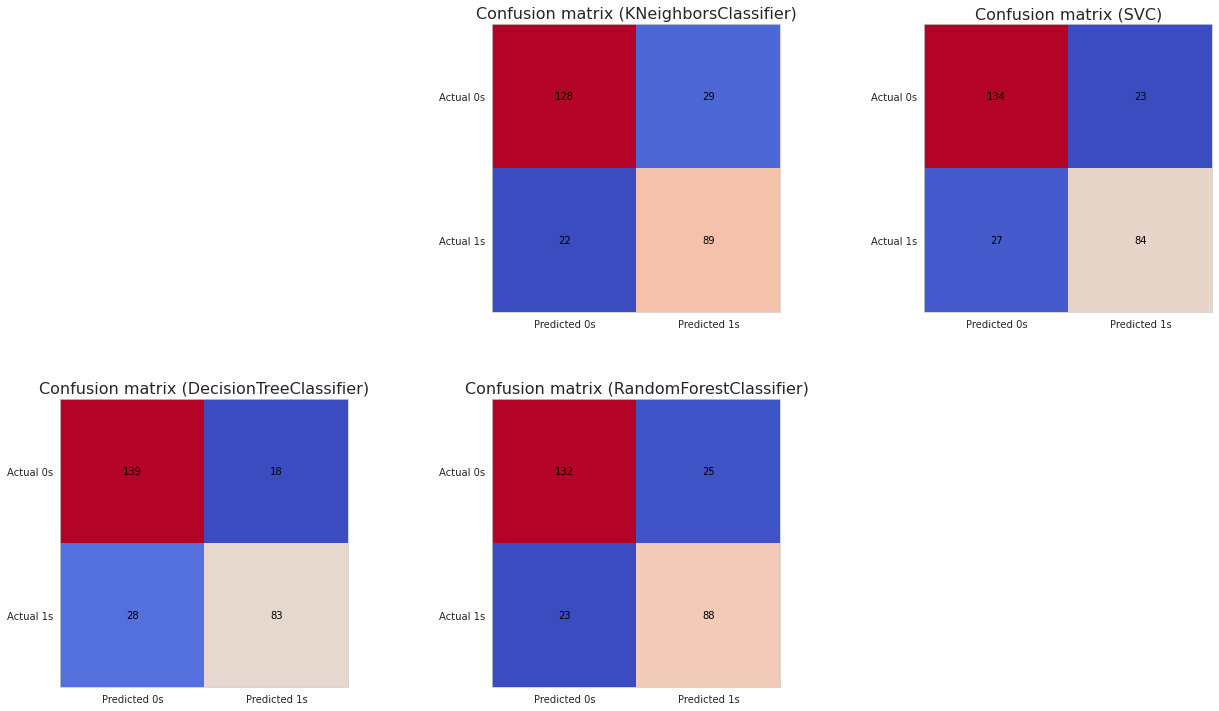

In [80]:
figure = plt.figure()
axes2 = figure.add_axes([1, 0, 1, 1]) # knn_model
axes3 = figure.add_axes([2, 0, 1, 1]) # svc_model
axes4 = figure.add_axes([0, -1.3, 1, 1]) # knn_model
axes5 = figure.add_axes([1, -1.3, 1, 1]) # knn_model

# knn_model
axes2.imshow(knn_cm, cmap='coolwarm')
axes2.grid(False)
axes2.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
axes2.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
axes2.set_title('Confusion matrix (KNeighborsClassifier)', fontsize=16)
for i in range(2):
    for j in range(2):
        axes2.text(j, i, knn_cm[i, j], ha='center', va='center', color='black')

# svc_model
axes3.imshow(svc_cm, cmap='coolwarm')
axes3.grid(False)
axes3.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
axes3.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
axes3.set_title('Confusion matrix (SVC)', fontsize=16)
for i in range(2):
    for j in range(2):
        axes3.text(j, i, svc_cm[i, j], ha='center', va='center', color='black')

# knn_model       
axes4.imshow(dt_cm, cmap='coolwarm')
axes4.grid(False)
axes4.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
axes4.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
axes4.set_title('Confusion matrix (DecisionTreeClassifier)', fontsize=16)
for i in range(2):
    for j in range(2):
        axes4.text(j, i, dt_cm[i, j], ha='center', va='center', color='black')

# rf_model       
axes5.imshow(rf_cm, cmap='coolwarm')
axes5.grid(False)
axes5.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
axes5.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
axes5.set_title('Confusion matrix (RandomForestClassifier)', fontsize=16)
for i in range(2):
    for j in range(2):
        axes5.text(j, i, rf_cm[i, j], ha='center', va='center', color='black')

In [82]:
models = ['KNeighborsClassifier', 'SVM', 'DecisionTreeClassifier', 'RandomForestClassifier']
scores = [knn_score, svc_score, dt_score, rf_score]
score_table = pd.DataFrame({'Model':models, 'Score':scores})
score_table.sort_values(by='Score', axis=0, ascending=False)

,Model,Score
3,RandomForestClassifier,0.861032
2,DecisionTreeClassifier,0.838070
0,KNeighborsClassifier,0.834199
1,SVM,0.821485
